# Acoustic signal feature extraction
### Notebook 4: Feature extraction for ML
- Author： Chen Lequn
- Experiment date: __June__
- Extraction of key acoustic features for training traditional ML models

In [95]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage.transform import resize

## Audio signal processing libraries
import librosa
import librosa.display
import IPython.display as ipd
from scipy.fftpack import fft

# ------------------- plotly visualizatoin----------------------------------
from PIL import Image
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from skimage import data

import matplotlib.pyplot as plt
# Use grid search with cross validation to select ML model hyper-parameters:
from sklearn.model_selection import train_test_split  # random split the data into "training data" and "testing data"
from sklearn.model_selection import GridSearchCV  # Exhaustive grid search with cross validation (CV)
from sklearn import metrics
from sklearn.metrics import classification_report


import scaleogram as scg 
from glob import glob
import glob
import re
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf

In [94]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [2]:
# Pytorch libraryes and torchaudio - for GPU accelerated feature extraction
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary

import plotly.express as px
import plotly.io as pio
import nussl
import natsort

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [115]:
# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"
Audio_PATH_original = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "original", 'train')
Audio_PATH_original_seg = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "original", "train_seg")
Audio_PATH_equalized = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "equalized")
Audio_PATH_bandpassed = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "bandpassed")
Audio_PATH_denoised = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "denoised", 'train')

Audio_PATH_original_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "original", "sliced_layers")
Audio_PATH_equalized_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "equalized", "sliced_layers")
Audio_PATH_bandpass_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "bandpassed", "sliced_layers")
Audio_PATH_denoised_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "denoised", "sliced_layers")

label_file = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', 'label.csv')

Experiment_PATH = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment')
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'AMDataset_v4_June_Experiment', "Dataset_analysis")
os.makedirs(Audio_PATH_original, exist_ok=True)
os.makedirs(Audio_PATH_original_seg, exist_ok=True)
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [116]:
sys.path.insert(0, '../utils')

import utils
import utils_June_exp
import filter
import feature_extractions
from feature_extractions import amplitude_envelope
FRAME_SIZE = 2048
HOP_LENGTH = 512
from scipy.fftpack import fft

## Load label

In [117]:
labels = pd.read_csv(label_file)
labels

,Sample,layer,label,Label
0,25,1,0,Defect-free
1,25,2,0,Defect-free
2,25,3,0,Defect-free
3,25,4,0,Defect-free
4,25,5,0,Defect-free
...,...,...,...,...
155,24,56,2,Keyhole pores
156,24,57,2,Keyhole pores
157,24,58,2,Keyhole pores
158,24,59,2,Keyhole pores


## Load audio data (layer-wise)

In [118]:
AM_wav_original = glob.glob1(Audio_PATH_original_layer, '*.wav')
AM_wav_original = natsort.natsorted(AM_wav_original)
for i in range(len(AM_wav_original)):
    AM_wav_original[i]= Audio_PATH_original_layer + "\\" + AM_wav_original[i]
print(f'Total wav file in Audio_PATH_original_layer folder :{len(AM_wav_original)}')


AM_wav_equalized = glob.glob1(Audio_PATH_equalized_layer, '*.wav')
AM_wav_equalized = natsort.natsorted(AM_wav_equalized)
for i in range(len(AM_wav_equalized)):
    AM_wav_equalized[i]= Audio_PATH_equalized_layer + "\\" + AM_wav_equalized[i]
print(f'Total wav file in Audio_PATH_equalized_layer folder :{len(AM_wav_equalized)}')


AM_wav_bandpass = glob.glob1(Audio_PATH_bandpass_layer, '*.wav')
AM_wav_bandpass = natsort.natsorted(AM_wav_bandpass)
for i in range(len(AM_wav_bandpass)):
    AM_wav_bandpass[i]= Audio_PATH_bandpass_layer + "\\" + AM_wav_bandpass[i]
print(f'Total wav file in Audio_PATH_bandpass_layer folder :{len(AM_wav_bandpass)}')


AM_wav_denoised = glob.glob1(Audio_PATH_denoised_layer, '*.wav')
AM_wav_denoised = natsort.natsorted(AM_wav_denoised)
for i in range(len(AM_wav_denoised)):
    AM_wav_denoised[i]= Audio_PATH_denoised_layer + "\\" + AM_wav_denoised[i]
    
print(f'Total wav file in Audio_PATH_denoised_layer folder :{len(AM_wav_denoised)}')


dataset_original = []
dataset_equalized = []
dataset_bandpassed= []
dataset_denoised = []


def generate_structured_datset(files, dataset_name):
    for file in files:
        # exp_25_denoised_layer_28.wav
        # experiment number is second (1) position, layer number is 4 position, category (denoised/original) is position 2
        experiment_number = int(os.path.basename(file).split("_")[1])  
        layer_number_wav = os.path.basename(file).split("_")[4]
        separator = '.'
        layer_number = int(layer_number_wav.split(separator, 1)[0])
        # slice_number = os.path.basename(file).split("_")[5]
        signal_category = os.path.basename(file).split("_")[2]
        filename = os.path.basename(file)
        filepath = file
        dur = librosa.get_duration(filename = file)
        signal = librosa.load(file, sr=None)[0]
        # compile label wav
        dataset_name.append({'filename': filename,
                                 'wav_duration' : dur,
                                 'file_path' : filepath,
                                 'Sample' : experiment_number,
                                 'layer' : layer_number,
                                 'signal_category' : signal_category,
                                 'signal': signal,
                                })
    print ("dataset created")
        
generate_structured_datset(AM_wav_original, dataset_original)
generate_structured_datset(AM_wav_equalized, dataset_equalized)
generate_structured_datset(AM_wav_bandpass, dataset_bandpassed)
generate_structured_datset(AM_wav_denoised, dataset_denoised)

Total wav file in Audio_PATH_original_layer folder :170
Total wav file in Audio_PATH_equalized_layer folder :170
Total wav file in Audio_PATH_bandpass_layer folder :170
Total wav file in Audio_PATH_denoised_layer folder :170
dataset created
dataset created
dataset created
dataset created


### convert dataset into dataframe

In [119]:
### convert AM_dataset into dataframe
df_dataset_original = pd.DataFrame(dataset_original)
df_dataset_equalized = pd.DataFrame(dataset_equalized)
df_dataset_bandpassed = pd.DataFrame(dataset_bandpassed)
df_dataset_denoised = pd.DataFrame(dataset_denoised)

print(f'df_dataset_original : {df_dataset_original.shape}')
print(f'df_dataset_equalized : {df_dataset_equalized.shape}')
print(f'df_dataset_bandpassed : {df_dataset_bandpassed.shape}')
print(f'df_dataset_denoised : {df_dataset_denoised.shape}')

df_dataset_denoised.head()

df_dataset_original : (170, 7)
df_dataset_equalized : (170, 7)
df_dataset_bandpassed : (170, 7)
df_dataset_denoised : (170, 7)


,filename,wav_duration,file_path,Sample,layer,signal_category,signal
0,exp_22_denoised_layer_1.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,1,denoised,"[-0.022155762, -0.030181885, -0.0073242188, 0...."
1,exp_22_denoised_layer_2.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,2,denoised,"[0.030639648, -0.07736206, -0.08932495, 0.0111..."
2,exp_22_denoised_layer_3.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,3,denoised,"[-0.015808105, 0.014709473, 0.017303467, -0.00..."
3,exp_22_denoised_layer_4.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,4,denoised,"[-0.079559326, -0.04156494, 0.045043945, 0.062..."
4,exp_22_denoised_layer_5.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,5,denoised,"[-0.01687622, 0.011474609, 0.027740479, 0.0077..."


In [120]:
print (df_dataset_original["file_path"][1])

../AM_audio_dataset\AMDataset_v4_June_Experiment\wave_file\original\sliced_layers\exp_22_raw_layer_2.wav


In [121]:
df_dataset_original.head()

,filename,wav_duration,file_path,Sample,layer,signal_category,signal
0,exp_22_raw_layer_1.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,1,raw,"[0.0037231445, -0.0082092285, -0.007385254, 0...."
1,exp_22_raw_layer_2.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,2,raw,"[0.010101318, -0.034698486, -0.07284546, -0.06..."
2,exp_22_raw_layer_3.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,3,raw,"[0.00024414062, 0.009063721, 0.009399414, 0.00..."
3,exp_22_raw_layer_4.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,4,raw,"[-0.008056641, -0.023986816, 0.00076293945, 0...."
4,exp_22_raw_layer_5.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,5,raw,"[-0.028503418, -0.027801514, -0.019470215, -0...."


In [122]:
df_dataset_original = pd.merge(df_dataset_original, labels)
df_dataset_equalized = pd.merge(df_dataset_equalized, labels)
df_dataset_bandpassed = pd.merge(df_dataset_bandpassed, labels)
df_dataset_denoised = pd.merge(df_dataset_denoised, labels)

In [123]:
df_dataset_original.head()

,filename,wav_duration,file_path,Sample,layer,signal_category,signal,label,Label
0,exp_22_raw_layer_1.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,1,raw,"[0.0037231445, -0.0082092285, -0.007385254, 0....",0,Defect-free
1,exp_22_raw_layer_2.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,2,raw,"[0.010101318, -0.034698486, -0.07284546, -0.06...",0,Defect-free
2,exp_22_raw_layer_3.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,3,raw,"[0.00024414062, 0.009063721, 0.009399414, 0.00...",0,Defect-free
3,exp_22_raw_layer_4.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,4,raw,"[-0.008056641, -0.023986816, 0.00076293945, 0....",0,Defect-free
4,exp_22_raw_layer_5.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,5,raw,"[-0.028503418, -0.027801514, -0.019470215, -0....",0,Defect-free


## Exploratory data analysis

In [124]:
df_dataset_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 159
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         160 non-null    object 
 1   wav_duration     160 non-null    float64
 2   file_path        160 non-null    object 
 3   Sample           160 non-null    int64  
 4   layer            160 non-null    int64  
 5   signal_category  160 non-null    object 
 6   signal           160 non-null    object 
 7   label            160 non-null    int64  
 8   Label            160 non-null    object 
dtypes: float64(1), int64(3), object(5)
memory usage: 12.5+ KB


In [125]:
categories = df_dataset_denoised['Label'].unique() # five unique labels
categories

array(['Defect-free', 'Cracks', 'Keyhole pores'], dtype=object)

### Data distribution

Saving figure dataset


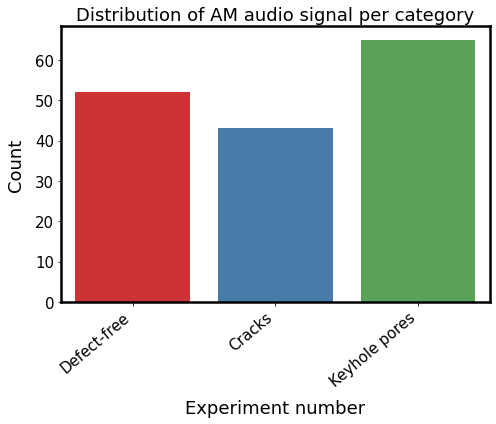

In [126]:
# sns.set(style="darkgrid")
plt.figure(figsize = (7,6))


ax = sns.countplot(x='Label', data = df_dataset_denoised, palette="Set1"); #palette='mako' 'Set2'
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# ax = sns.countplot(y='label', data = df_dataset_denoised, palette="Set2");


ax.set_title('Distribution of AM audio signal per category', fontsize = 18);
ax.set_xlabel("Experiment number",fontsize=18, labelpad=10)
ax.set_ylabel("Count",fontsize=18, labelpad=10)
ax.tick_params(labelsize=15)

save_fig("dataset")

### Ramdon checking

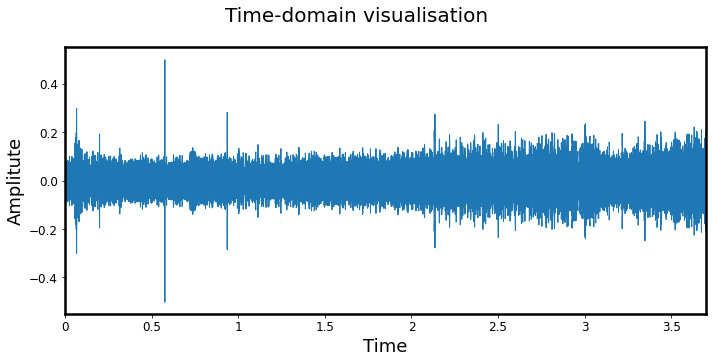

In [127]:
# signal, sr = librosa.load(AM_wav_denoised[20], sr=None)
signal = df_dataset_equalized.signal[20]
utils.simple_visualization(signal)

Text(0.5, 0, 'Time')

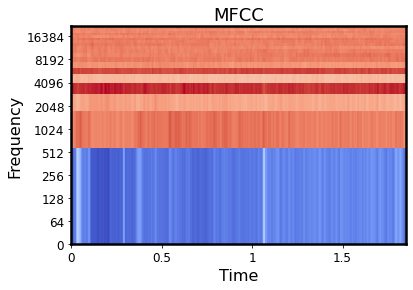

In [128]:
# get the mfcc feature
mfccs = librosa.feature.mfcc(y =signal, sr = 44100, n_mfcc = 20)

img=librosa.display.specshow(mfccs, 
                            sr=44100, 
                            hop_length=256, 
                            x_axis="time", 
                            y_axis='log',
                            # cmap=cmap, #'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'jet'
                            # vmin = vmin, vmax = vmax
                            )
# plt.colorbar(img, format="%+5.f dB")
# plt.colorbar(img)
plt.title("MFCC", fontsize=18)
plt.ylabel('Frequency', fontsize = 16)
plt.xlabel('Time', fontsize = 16)  #(μs)

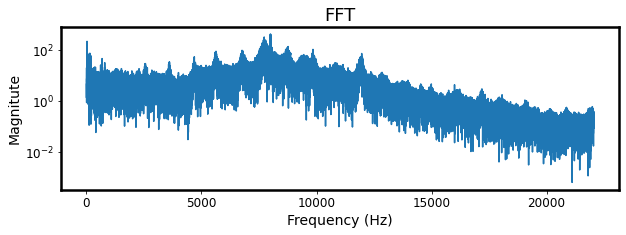

In [129]:
utils.plot_magnitude_spectrum_single(signal, 44100, "FFT", log_y=True, log_x = False)

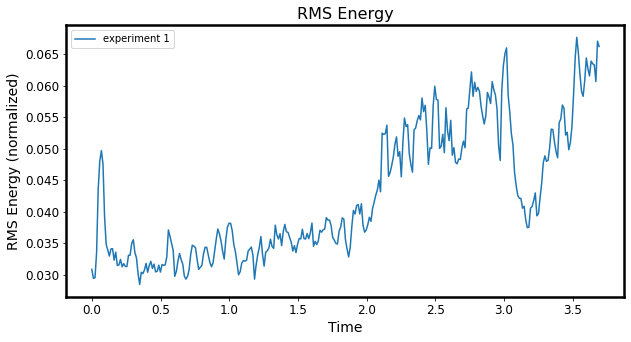

In [130]:
feature_extractions.visualize_rms_smooth([signal],FRAME_SIZE,HOP_LENGTH, 44100, N_smooth = 1)

# Feature extraction for traditional ML

- Time-domain features:
    - Amplitude envolope (AE)
    - RMS Energy
    - zero crossing rate
- Frequency domain features:
    - band energy ratio (BER)

- time-freqeuncy features:
    - Spectral centroid (frequency-domain feature)
    - Spectral bandwdith
    - Spectral flatness
    - Spectral rolloff 85%
    - Spectral contrast
    - Spectral variance
    - Spectral Crest
    - Spectral Skewness
    - Spectral Kurtosis

### AE

In [131]:
def extract_ae_feature(df_dataset_sound):
    ae_list = []
    ae_mean_list = []
    ae_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        ae = amplitude_envelope(sample_data, FRAME_SIZE, HOP_LENGTH)
        ae_list.append(ae)

    for ae in ae_list:
        ae_mean_list.append(np.mean(ae))
        ae_var_list.append(np.var(ae))
        
    df_dataset_sound['AE mean'] = ae_mean_list
    df_dataset_sound['AE var'] = ae_var_list

In [132]:
extract_ae_feature(df_dataset_original)
extract_ae_feature(df_dataset_equalized)
extract_ae_feature(df_dataset_bandpassed)
extract_ae_feature(df_dataset_denoised)

In [133]:
df_dataset_denoised.head()

,filename,wav_duration,file_path,Sample,layer,signal_category,signal,label,Label,AE mean,AE var
0,exp_22_denoised_layer_1.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,1,denoised,"[-0.022155762, -0.030181885, -0.0073242188, 0....",0,Defect-free,0.112763,0.005286
1,exp_22_denoised_layer_2.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,2,denoised,"[0.030639648, -0.07736206, -0.08932495, 0.0111...",0,Defect-free,0.110001,0.004914
2,exp_22_denoised_layer_3.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,3,denoised,"[-0.015808105, 0.014709473, 0.017303467, -0.00...",0,Defect-free,0.108993,0.008392
3,exp_22_denoised_layer_4.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,4,denoised,"[-0.079559326, -0.04156494, 0.045043945, 0.062...",0,Defect-free,0.104171,0.002537
4,exp_22_denoised_layer_5.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,5,denoised,"[-0.01687622, 0.011474609, 0.027740479, 0.0077...",0,Defect-free,0.083356,0.000929


### RMSE

In [134]:
def extract_rmse_feature(df_dataset_sound):
    rms_list = []
    rms_mean_list = []
    rms_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        rms = librosa.feature.rms(sample_data, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        rms_list.append(rms)

    for rms in rms_list:
        rms_mean_list.append(np.mean(rms))
        rms_var_list.append(np.var(rms))
        
    df_dataset_sound['RMSE mean'] = rms_mean_list
    df_dataset_sound['RMSE var'] = rms_var_list

In [135]:
extract_rmse_feature(df_dataset_original)
extract_rmse_feature(df_dataset_equalized)
extract_rmse_feature(df_dataset_bandpassed)
extract_rmse_feature(df_dataset_denoised)

In [136]:
df_dataset_denoised.head()

,filename,wav_duration,file_path,Sample,layer,signal_category,signal,label,Label,AE mean,AE var,RMSE mean,RMSE var
0,exp_22_denoised_layer_1.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,1,denoised,"[-0.022155762, -0.030181885, -0.0073242188, 0....",0,Defect-free,0.112763,0.005286,0.028401,0.000040
1,exp_22_denoised_layer_2.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,2,denoised,"[0.030639648, -0.07736206, -0.08932495, 0.0111...",0,Defect-free,0.110001,0.004914,0.028319,0.000051
2,exp_22_denoised_layer_3.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,3,denoised,"[-0.015808105, 0.014709473, 0.017303467, -0.00...",0,Defect-free,0.108993,0.008392,0.025786,0.000087
3,exp_22_denoised_layer_4.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,4,denoised,"[-0.079559326, -0.04156494, 0.045043945, 0.062...",0,Defect-free,0.104171,0.002537,0.027605,0.000054
4,exp_22_denoised_layer_5.wav,3.7,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,5,denoised,"[-0.01687622, 0.011474609, 0.027740479, 0.0077...",0,Defect-free,0.083356,0.000929,0.022692,0.000041


### ZCR

In [137]:
def extract_zcr_feature(df_dataset_sound):
    zcr_list = []
    zcr_mean_list = []
    zcr_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        zcr = librosa.feature.zero_crossing_rate(sample_data, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        zcr_list.append(zcr)

    for zcr in zcr_list:
        zcr_mean_list.append(np.mean(zcr))
        zcr_var_list.append(np.var(zcr))
        
    df_dataset_sound['ZCR mean'] = zcr_mean_list
    df_dataset_sound['ZCR var'] = zcr_var_list

In [138]:
extract_zcr_feature(df_dataset_original)
extract_zcr_feature(df_dataset_equalized)
extract_zcr_feature(df_dataset_bandpassed)
extract_zcr_feature(df_dataset_denoised)

In [139]:
# df_dataset_original.head()

### Spectral centroid (frequency-domain feature)
- The concentration of energy

In [140]:
sr = 44100
def extract_spectral_centroid(df_dataset_sound):
    spectral_centroid_list = []
    sc_mean_list = []
    sc_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        sc = librosa.feature.spectral_centroid(y=sample_data, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        spectral_centroid_list.append(sc)

    for sc in spectral_centroid_list:
        sc_mean_list.append(np.mean(sc))
        sc_var_list.append(np.var(sc))
        
    df_dataset_sound['S-centroid mean'] = sc_mean_list
    df_dataset_sound['S-centroid var'] = sc_var_list

In [141]:
extract_spectral_centroid(df_dataset_original)
extract_spectral_centroid(df_dataset_equalized)
extract_spectral_centroid(df_dataset_bandpassed)
extract_spectral_centroid(df_dataset_denoised)

### Spectral bandwidth

In [142]:
def extract_spectral_bandwidth(df_dataset_sound):
    spectral_bandwidth_list = []
    sb_mean_list = []
    sb_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=sample_data, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, p=2)[0]
        spectral_bandwidth_list.append(spectral_bandwidth)

    for sb in spectral_bandwidth_list:
        sb_mean_list.append(np.mean(sb))
        sb_var_list.append(np.var(sb))
        
    df_dataset_sound['S-bandwidth mean'] = sb_mean_list
    df_dataset_sound['S-bandwidth var'] = sb_var_list

In [143]:
extract_spectral_bandwidth(df_dataset_original)
extract_spectral_bandwidth(df_dataset_equalized)
extract_spectral_bandwidth(df_dataset_bandpassed)
extract_spectral_bandwidth(df_dataset_denoised)

### Spectral Roll-Off

In [144]:
def extract_spectral_rolloff(df_dataset_sound):
    spectral_rolloff_list = []
    rolloff_mean_list = []
    rolloff_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        rolloff = librosa.feature.spectral_rolloff(y=sample_data, sr=sr, roll_percent=0.85)
        spectral_rolloff_list.append(rolloff)

    for rolloff in spectral_rolloff_list:
        rolloff_mean_list.append(np.mean(rolloff))
        rolloff_var_list.append(np.var(rolloff))
        
    df_dataset_sound['Rolloff mean'] = rolloff_mean_list
    df_dataset_sound['Rolloff var'] = rolloff_var_list

In [145]:
extract_spectral_rolloff(df_dataset_original)
extract_spectral_rolloff(df_dataset_equalized)
extract_spectral_rolloff(df_dataset_bandpassed)
extract_spectral_rolloff(df_dataset_denoised)

### BER

In [146]:
def extract_ber(df_dataset_sound):
    ber_list = []
    ber_mean_list = []
    ber_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        Stft = librosa.stft(sample_data, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
        ber = feature_extractions.band_energy_ratio(Stft, split_frequency = 14000, sample_rate = sr)
        ber_list.append(ber)

    for ber in ber_list:
        ber_mean_list.append(np.mean(ber))
        ber_var_list.append(np.var(ber))
        
    df_dataset_sound['BER mean'] = ber_mean_list
    df_dataset_sound['BER var'] = ber_var_list

In [147]:
extract_ber(df_dataset_original)
extract_ber(df_dataset_equalized)
extract_ber(df_dataset_bandpassed)
extract_ber(df_dataset_denoised)

### Spectral Flatness

In [148]:
def extract_spectral_flatness(df_dataset_sound):
    spectral_flatness_list = []
    sf_mean_list = []
    sf_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        spectral_flatness = librosa.feature.spectral_flatness(sample_data, power=2, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        spectral_flatness_list.append(spectral_flatness)

    for sf in spectral_flatness_list:
        sf_mean_list.append(np.mean(sf))
        sf_var_list.append(np.var(sf))
        
    df_dataset_sound['S-flatness mean'] = sf_mean_list
    df_dataset_sound['S-flatness var'] = sf_var_list

In [149]:
extract_spectral_flatness(df_dataset_original)
extract_spectral_flatness(df_dataset_equalized)
extract_spectral_flatness(df_dataset_bandpassed)
extract_spectral_flatness(df_dataset_denoised)

### Spectral kurtosis

In [150]:
def extract_spectral_kurtosis(df_dataset_sound):
    spectral_kurtosis_list = []
    kurtosis_mean_list = []
    kurtosis_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        S, phase = librosa.magphase(librosa.stft(sample_data))
        # S_power = S **2   
        S_power = S
        s_kurtosis = feature_extractions.spectral_kurtosis(S_power)
        spectral_kurtosis_list.append(s_kurtosis)

    for sk in spectral_kurtosis_list:
        kurtosis_mean_list.append(np.mean(sk))
        kurtosis_var_list.append(np.var(sk))
        
    df_dataset_sound['S-kurtosis mean'] = kurtosis_mean_list
    df_dataset_sound['S-kurtosis var'] = kurtosis_var_list

In [151]:
extract_spectral_kurtosis(df_dataset_original)
extract_spectral_kurtosis(df_dataset_equalized)
extract_spectral_kurtosis(df_dataset_bandpassed)
extract_spectral_kurtosis(df_dataset_denoised)

### Spectral variance

In [152]:
def extract_spectral_variance(df_dataset_sound):
    spectral_variance_list = []
    variance_mean_list = []
    variance_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        S, phase = librosa.magphase(librosa.stft(sample_data))
        # S_power = S **2   
        S_power = S
        s_variance = feature_extractions.spectral_variance(S_power)
        spectral_variance_list.append(s_variance)

    for spectral_variance in spectral_variance_list:
        variance_mean_list.append(np.mean(spectral_variance))
        variance_var_list.append(np.var(spectral_variance))
        
    df_dataset_sound['S-variance mean'] = variance_mean_list
    df_dataset_sound['S-variance var'] = variance_var_list

In [153]:
extract_spectral_variance(df_dataset_original)
extract_spectral_variance(df_dataset_equalized)
extract_spectral_variance(df_dataset_bandpassed)
extract_spectral_variance(df_dataset_denoised)

### Spectral crest factor

In [154]:
def extract_spectral_crest(df_dataset_sound):
    spectral_crest_list = []
    spectral_crest_mean_list = []
    spectral_crest_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        S, phase = librosa.magphase(librosa.stft(sample_data))
        # S_power = S **2   
        S_power = S
        s_crest = feature_extractions.spectral_crest(S_power)
        spectral_crest_list.append(s_crest)

    for spectral_crest in spectral_crest_list:
        spectral_crest_mean_list.append(np.mean(spectral_crest))
        spectral_crest_var_list.append(np.var(spectral_crest))
        
    df_dataset_sound['S-crest mean'] = spectral_crest_mean_list
    df_dataset_sound['S-crest var'] = spectral_crest_var_list

In [155]:
extract_spectral_crest(df_dataset_original)
extract_spectral_crest(df_dataset_equalized)
extract_spectral_crest(df_dataset_bandpassed)
extract_spectral_crest(df_dataset_denoised)

### Spectral Skewness

In [156]:
def extract_spectral_skewness(df_dataset_sound):
    spectral_skewness_list = []
    spectral_skewness_mean_list = []
    spectral_skewness_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        S, phase = librosa.magphase(librosa.stft(sample_data))
        # S_power = S **2   
        S_power = S
        s_skewness = feature_extractions.spectral_skewness(S_power)
        spectral_skewness_list.append(s_skewness)

    for spectral_skewness in spectral_skewness_list:
        spectral_skewness_mean_list.append(np.mean(spectral_skewness))
        spectral_skewness_var_list.append(np.var(spectral_skewness))
        
    df_dataset_sound['S-skewness mean'] = spectral_skewness_mean_list
    df_dataset_sound['S-skewness var'] = spectral_skewness_var_list

In [157]:
extract_spectral_skewness(df_dataset_original)
extract_spectral_skewness(df_dataset_equalized)
extract_spectral_skewness(df_dataset_bandpassed)
extract_spectral_skewness(df_dataset_denoised)

## Spectral entropy

In [158]:
def extract_spectral_entropy(df_dataset_sound):
    spectral_entropy_list = []
    spectral_entropy_mean_list = []
    spectral_entropy_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        number_of_samples = len(sample_data)  # total number of samples
        current_position = 0
        count_fr = 0
        num_fft = int(FRAME_SIZE / 2)
        
        s_entropy_features = []
         # for each short-term window to end of signal
        while current_position + FRAME_SIZE - 1 < number_of_samples:
            count_fr += 1
            # get current window
            x = sample_data[current_position:current_position + FRAME_SIZE]

            # update window position
            current_position = current_position + HOP_LENGTH

            # get fft magnitude
            fft_magnitude = abs(fft(x))

            # normalize fft
            fft_magnitude = fft_magnitude[0:num_fft]
            fft_magnitude = fft_magnitude / len(fft_magnitude)

            # keep previous fft mag (used in spectral entropy)
            if count_fr == 1:
                fft_magnitude_previous = fft_magnitude.copy()

            s_entropy = feature_extractions.spectral_entropy(fft_magnitude,n_short_blocks=10)
            s_entropy_features.append(s_entropy)

            fft_magnitude_previous = fft_magnitude.copy()

        spectral_entropy_list.append(s_entropy_features)

    for spectral_entropy in spectral_entropy_list:
        spectral_entropy_mean_list.append(np.mean(spectral_entropy))
        spectral_entropy_var_list.append(np.var(spectral_entropy))
        
    df_dataset_sound['S-entropy mean'] = spectral_entropy_mean_list
    df_dataset_sound['S-entropy var'] = spectral_entropy_var_list

In [159]:
extract_spectral_entropy(df_dataset_original)
extract_spectral_entropy(df_dataset_equalized)
extract_spectral_entropy(df_dataset_bandpassed)
extract_spectral_entropy(df_dataset_denoised)

### Spectral flux

In [160]:
def extract_spectral_flux(df_dataset_sound):
    spectral_flux_list = []
    spectral_flux_mean_list = []
    spectral_flux_var_list = []

    for i, sample_data in enumerate(df_dataset_sound['signal']):
        number_of_samples = len(sample_data)  # total number of samples
        current_position = 0
        count_fr = 0
        num_fft = int(FRAME_SIZE / 2)

        s_flux_features = []
         # for each short-term window to end of signal
        while current_position + FRAME_SIZE - 1 < number_of_samples:
            count_fr += 1
            # get current window
            x = sample_data[current_position:current_position + FRAME_SIZE]

            # update window position
            current_position = current_position + HOP_LENGTH

            # get fft magnitude
            fft_magnitude = abs(fft(x))

            # normalize fft
            fft_magnitude = fft_magnitude[0:num_fft]
            fft_magnitude = fft_magnitude / len(fft_magnitude)

            # keep previous fft mag (used in spectral flux)
            if count_fr == 1:
                fft_magnitude_previous = fft_magnitude.copy()

            s_flux = feature_extractions.spectral_flux(fft_magnitude,fft_magnitude_previous)
            s_flux_features.append(s_flux)

            fft_magnitude_previous = fft_magnitude.copy()

        spectral_flux_list.append(s_flux_features)

    for spectral_flux in spectral_flux_list:
        spectral_flux_mean_list.append(np.mean(spectral_flux))
        spectral_flux_var_list.append(np.var(spectral_flux))
        
    df_dataset_sound['S-flux mean'] = spectral_flux_mean_list
    df_dataset_sound['S-flux var'] = spectral_flux_var_list

In [161]:
extract_spectral_flux(df_dataset_original)
extract_spectral_flux(df_dataset_equalized)
extract_spectral_flux(df_dataset_bandpassed)
extract_spectral_flux(df_dataset_denoised)

## Feature analysis

In [162]:
df_dataset_denoised.groupby('Label').describe()

wav_duration                                                    \
                     count      mean       std  min  25%       50%       75%   
Label                                                                          
Cracks                43.0  4.226357  0.775350  3.0  3.7  3.700000  5.016667   
Defect-free           52.0  4.286218  0.860857  3.0  3.7  5.016667  5.016667   
Keyhole pores         65.0  3.567436  0.729913  3.0  3.0  3.000000  3.700000   

                        Sample             ... S-flux mean            \
                    max  count       mean  ...         75%       max   
Label                                      ...                         
Cracks         5.016667   43.0  23.348837  ...    0.000921  0.001054   
Defect-free    5.016667   52.0  23.750000  ...    0.001030  0.001094   
Keyhole pores  5.016667   65.0  23.861538  ...    0.000898  0.000951   

              S-flux var                                            \
                   count          mean           std           min   
Label                                                                
Cracks              43.0  7.779006e-08  2.927360e-08  3.953464e-08   
Defect-free         52.0  7.632306e-08  1.812009e-08  3.470311e-08   
Keyhole pores       65.0  6.060638e-08  3.338714e-08  1.614581e-08   

                                                                       
                        25%           50%           75%           max  
Label                                                                  
Cracks         5.643024e-08  6.926398e-08  8.771502e-08  1.606501e-07  
Defect-free    6.447202e-08  7.427930e-08  8.289608e-08  1.354168e-07  
Keyhole pores  2.866734e-08  6.085768e-08  8.469615e-08  1.509358e-07  

[3 rows x 256 columns]

In [163]:
df_dataset_equalized.columns

Index(['filename', 'wav_duration', 'file_path', 'Sample', 'layer',
       'signal_category', 'signal', 'label', 'Label', 'AE mean', 'AE var',
       'RMSE mean', 'RMSE var', 'ZCR mean', 'ZCR var', 'S-centroid mean',
       'S-centroid var', 'S-bandwidth mean', 'S-bandwidth var', 'Rolloff mean',
       'Rolloff var', 'BER mean', 'BER var', 'S-flatness mean',
       'S-flatness var', 'S-kurtosis mean', 'S-kurtosis var',
       'S-variance mean', 'S-variance var', 'S-crest mean', 'S-crest var',
       'S-skewness mean', 'S-skewness var', 'S-entropy mean', 'S-entropy var',
       'S-flux mean', 'S-flux var'],
      dtype='object')

In [165]:
df_dataset_original_selected = df_dataset_original[[ 'Label', 'label', 'AE mean', 'AE var', 'RMSE mean',
                                                     'RMSE var', 'ZCR mean', 'ZCR var', 'Rolloff mean', 'Rolloff var',
                                                     'BER mean', 'BER var', 'S-centroid mean', 'S-centroid var', 'S-bandwidth mean', 'S-bandwidth var',
                                                     'S-flatness mean', 'S-flatness var', 'S-kurtosis mean', 'S-kurtosis var',
                                                     'S-variance mean', 'S-variance var', 'S-crest mean', 'S-crest var',
                                                     'S-skewness mean', 'S-skewness var', 'S-entropy mean', 'S-entropy var',
                                                     'S-flux mean', 'S-flux var']]

df_dataset_equalized_selected = df_dataset_equalized[[ 'Label', 'label', 'AE mean', 'AE var', 'RMSE mean',
                                                     'RMSE var', 'ZCR mean', 'ZCR var', 'Rolloff mean', 'Rolloff var',
                                                     'BER mean', 'BER var', 'S-centroid mean', 'S-centroid var', 'S-bandwidth mean', 'S-bandwidth var',
                                                     'S-flatness mean', 'S-flatness var', 'S-kurtosis mean', 'S-kurtosis var',
                                                     'S-variance mean', 'S-variance var', 'S-crest mean', 'S-crest var',
                                                     'S-skewness mean', 'S-skewness var', 'S-entropy mean', 'S-entropy var',
                                                     'S-flux mean', 'S-flux var']]

df_dataset_bandpassed_selected = df_dataset_bandpassed[['Label', 'label', 'AE mean', 'AE var', 'RMSE mean',
                                                     'RMSE var', 'ZCR mean', 'ZCR var', 'Rolloff mean', 'Rolloff var',
                                                     'BER mean', 'BER var', 'S-centroid mean', 'S-centroid var', 'S-bandwidth mean', 'S-bandwidth var',
                                                     'S-flatness mean', 'S-flatness var', 'S-kurtosis mean', 'S-kurtosis var',
                                                     'S-variance mean', 'S-variance var', 'S-crest mean', 'S-crest var',
                                                     'S-skewness mean', 'S-skewness var', 'S-entropy mean', 'S-entropy var',
                                                     'S-flux mean', 'S-flux var']]

df_dataset_denoised_selected = df_dataset_denoised[[ 'Label', 'label', 'AE mean', 'AE var', 'RMSE mean',
                                                     'RMSE var', 'ZCR mean', 'ZCR var', 'Rolloff mean', 'Rolloff var',
                                                     'BER mean', 'BER var', 'S-centroid mean', 'S-centroid var', 'S-bandwidth mean', 'S-bandwidth var',
                                                     'S-flatness mean', 'S-flatness var', 'S-kurtosis mean', 'S-kurtosis var',
                                                     'S-variance mean', 'S-variance var', 'S-crest mean', 'S-crest var',
                                                     'S-skewness mean', 'S-skewness var', 'S-entropy mean', 'S-entropy var',
                                                     'S-flux mean', 'S-flux var']]

In [84]:
# df_dataset_original['label']

Saving figure correlation matrix (equalized) - layerwise


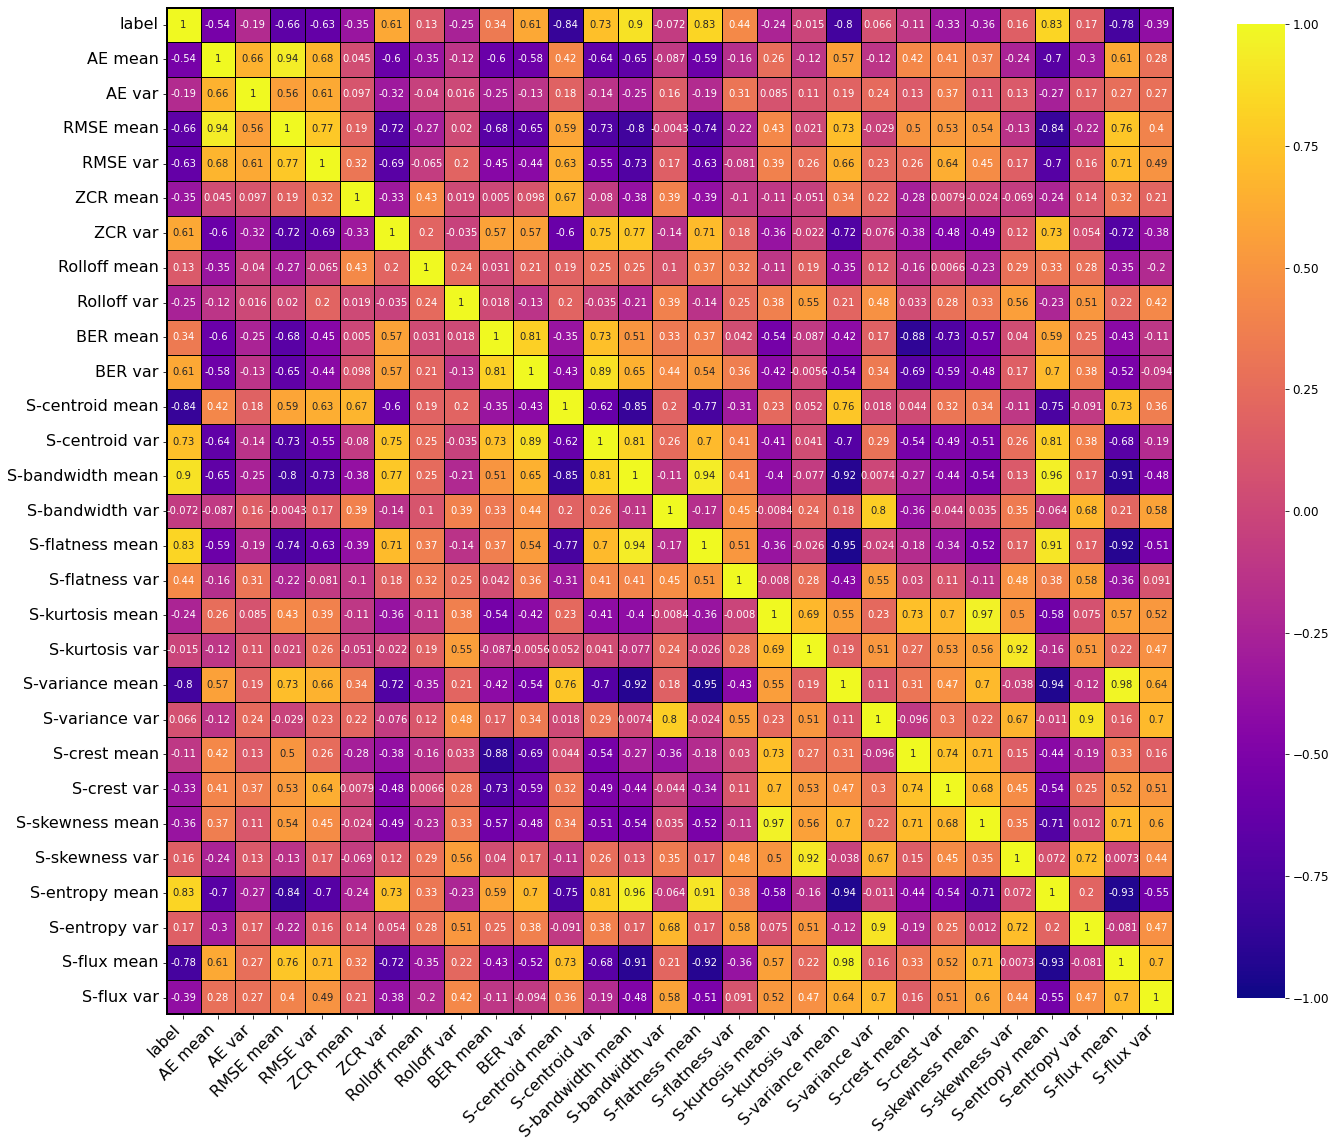

In [169]:
corr = df_dataset_equalized_selected.corr(method='spearman')
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches

sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    # cmap=sns.diverging_palette(20, 220, n=200),
    cmap="plasma",
    square=True,
    ax=ax,
    annot=True,
    cbar_kws={"shrink": .7},
    linewidths=0.5, linecolor='black'
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 16,
)

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    # horizontalalignment='right',
    fontsize = 16
)

ax.axhline(y=0, color='k',linewidth=4)
ax.axhline(y=corr.shape[1], color='k',linewidth=4)
ax.axvline(x=0, color='k',linewidth=4)
ax.axvline(x=corr.shape[0], color='k',linewidth=4)

save_fig("correlation matrix (equalized) - layerwise")

## Constructing labels and input features for training the models

In [170]:
feature_selected_list = ['AE mean', 'AE var', 'RMSE mean',
                         'RMSE var', 'ZCR mean', 'ZCR var', 'Rolloff mean', 'Rolloff var',
                         'BER mean', 'BER var', 'S-centroid mean', 'S-centroid var', 'S-bandwidth mean', 'S-bandwidth var',
                         'S-flatness mean', 'S-flatness var', 'S-kurtosis mean', 'S-kurtosis var',
                         'S-variance mean', 'S-variance var', 'S-crest mean', 'S-crest var',
                         'S-skewness mean', 'S-skewness var', 'S-entropy mean', 'S-entropy var',
                         'S-flux mean', 'S-flux var']

In [171]:
# Label = df_dataset_original_500_selected['Label'].to_list()
y_original = df_dataset_original_selected['label'].to_list()
X_original = df_dataset_original_selected[feature_selected_list].to_numpy()

#----------------------------------------------------------------------------
y_equalized = df_dataset_equalized_selected['label'].to_list()
X_equalized = df_dataset_equalized_selected[feature_selected_list].to_numpy()


#----------------------------------------------------------------------------
y_bandpassed = df_dataset_bandpassed_selected['label'].to_list()
X_bandpassed = df_dataset_bandpassed_selected[feature_selected_list].to_numpy()

#----------------------------------------------------------------------------
y_denoised = df_dataset_denoised_selected['label'].to_list()
X_denoised = df_dataset_denoised_selected[feature_selected_list].to_numpy()


[0.04260948 0.00665278 0.04693219 0.00949952 0.03925982 0.03154596
 0.01649134 0.02487256 0.02650758 0.01567945 0.04586889 0.07581648
 0.11438886 0.01346343 0.09652654 0.03222076 0.01659621 0.02098553
 0.07808794 0.0285296  0.02185094 0.         0.01687478 0.01924642
 0.10233789 0.01674611 0.04040894 0.        ]
Saving figure feature_importance (denoised) layerwise


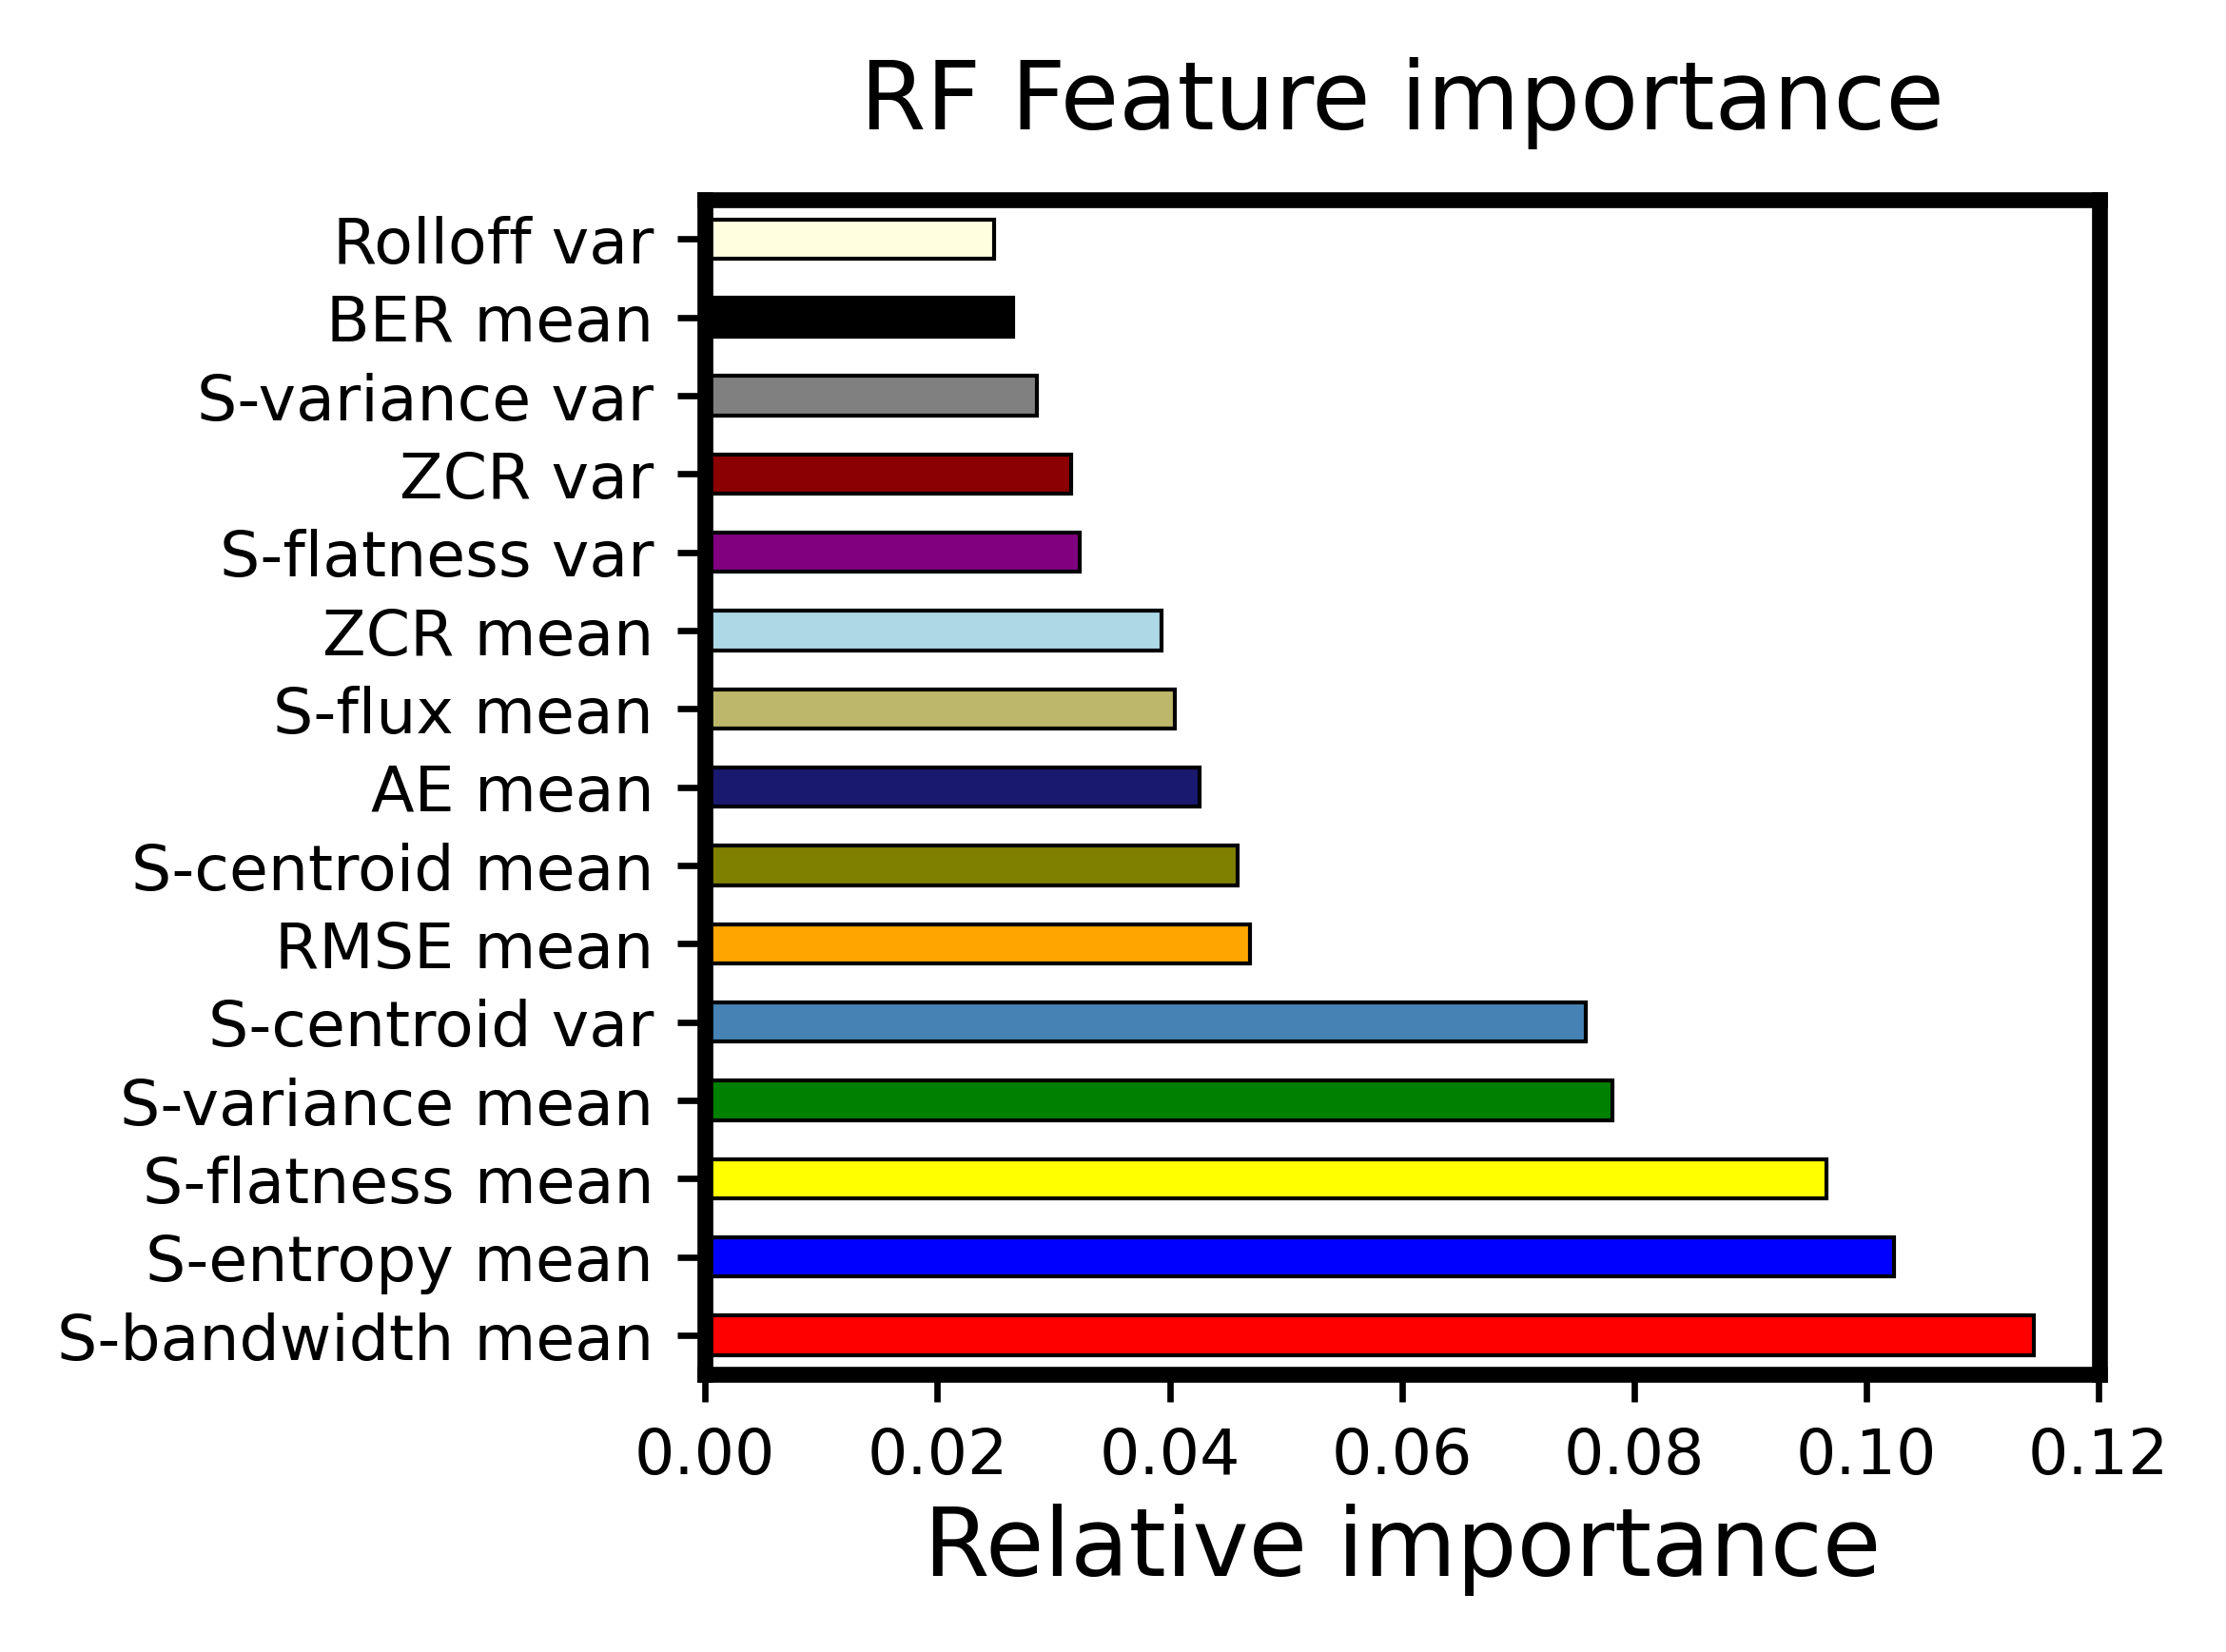

In [178]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca


fig = plt.figure(figsize = (4,3), dpi = 600)
widths = 2
ax = gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(widths)

    tick_width = 1.5

model = RandomForestClassifier()
model.fit(df_dataset_denoised_selected[feature_selected_list], y_original)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=df_dataset_denoised_selected[feature_selected_list].columns)


color=['red', 'blue','yellow','green', 'steelblue','orange', 'olive', 'midnightblue', 'darkkhaki', 
       "lightblue", "purple", "darkred", "gray", "black", "lightyellow"] #'darkkhaki'

feat_importances.nlargest(15).plot(kind='barh', color = color,edgecolor='k', linewidth =0.5)
plt.title("RF Feature importance",  fontsize = 12, y=1.02)
plt.xlabel('Relative importance', fontsize = 12, labelpad = 2)
plt.tick_params(axis='both', labelsize=8, pad = 3)
# plt.xaxis.set_tick_params(pad=1)
# plt.ylabel(fontsize = 14, labelpad = 5)

# plt.show()
save_fig("feature_importance (denoised) layerwise")


### Final selected features

In [183]:
feature_selected_list = ['label', 'S-bandwidth mean', 'S-entropy mean','S-flatness mean', 'S-variance mean', 'S-centroid var',
                        "RMSE mean",'S-centroid mean','AE mean', 
                         'S-flux mean','ZCR mean'] 
                         # 'S-skewness mean','S-kurtosis mean', 'Energy entropy mean',
                         # 'S-entropy var', 'S-variance var'
        
# feature_selected_list = ['AE mean', 'S-bandwidth mean', 'S-Flatness mean',"RMSE var",
#                          'S-crest mean','S-variance mean','AE var', 'S-flux mean', 'S-entropy mean',
#                          'S-centroid var', 'S-skewness mean','S-kurtosis mean', 'Energy entropy var',
#                          'S-entropy var', 'S-variance var'] 

df_dataset_original_selected_final = df_dataset_original_selected[feature_selected_list]
df_dataset_equalized_selected_final = df_dataset_equalized_selected[feature_selected_list]
df_dataset_bandpassed_selected_final = df_dataset_bandpassed_selected[feature_selected_list]
df_dataset_denoised_selected_final = df_dataset_denoised_selected[feature_selected_list]



X_original = df_dataset_original_selected_final[feature_selected_list].to_numpy()
#----------------------------------------------------------------------------
X_equalized = df_dataset_equalized_selected_final[feature_selected_list].to_numpy()
#----------------------------------------------------------------------------
X_bandpassed = df_dataset_bandpassed_selected_final[feature_selected_list].to_numpy()
#----------------------------------------------------------------------------
X_denoised = df_dataset_denoised_selected_final[feature_selected_list].to_numpy()

In [ ]:
corr = df_dataset_original_selected_final.corr(method='spearman')
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    # cmap=sns.diverging_palette(20, 220, n=200),
    cmap="plasma",
    square=True,
    ax=ax,
    annot=True,
    annot_kws={"size":12},
    cbar_kws={"shrink": .7,
             "ticks": [-1,-0.5, 0,0.5, 1]},
    fmt='.2f',
    linewidths=0.5, linecolor='white'
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 16,
)

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    # horizontalalignment='right',
    fontsize = 16
)

ax.set_title("Spearman feature correlation matrix", fontsize = 24, pad = 16)
ax.axhline(y=0, color='k',linewidth=3)
ax.axhline(y=corr.shape[1], color='k',linewidth=3)
ax.axvline(x=0, color='k',linewidth=3)
ax.axvline(x=corr.shape[0], color='k',linewidth=3)

save_fig("correlation matrix (raw) - layerwise selected")

In [185]:
df_dataset_original_selected.to_csv('..\\outputs\\June_experiments\\layer_prediction\\df_dataset_original.csv', index = False, mode='a')
df_dataset_equalized_selected.to_csv('..\\outputs\\June_experiments\\layer_prediction\\df_dataset_equalized.csv', index = False, mode='a')
df_dataset_bandpassed_selected.to_csv('..\\outputs\\June_experiments\\layer_prediction\\df_dataset_bandpassed.csv', index = False, mode='a')
df_dataset_denoised_selected.to_csv('..\\outputs\\June_experiments\\layer_prediction\\df_dataset_denoised.csv', index = False, mode='a')

## Data-pre processing, cleaning, unsupervised learning

#### Data Standarization (zero mean and unit variance)

In [186]:
from sklearn.preprocessing import StandardScaler

# # normalize the data before applying the fit method
df_original_normalized=(df_dataset_original_selected.select_dtypes(include=np.number) - df_dataset_original_selected.mean(numeric_only = True)) / df_dataset_original_selected.std(numeric_only = True)
df_equalized_normalized=(df_dataset_equalized_selected.select_dtypes(include=np.number) - df_dataset_equalized_selected.mean(numeric_only = True)) / df_dataset_equalized_selected.std(numeric_only = True)
df_bandpassed_normalized=(df_dataset_bandpassed_selected.select_dtypes(include=np.number) - df_dataset_bandpassed_selected.mean(numeric_only = True)) / df_dataset_bandpassed_selected.std(numeric_only = True)
df_denoised_normalized=(df_dataset_denoised_selected.select_dtypes(include=np.number) - df_dataset_denoised_selected.mean(numeric_only = True)) / df_dataset_denoised_selected.std(numeric_only = True)
# ## note that if using Sklearn preprocessing function, the dataframe will be converted to numpy array

# df_original_normalized = df_original_normalized.join(df_dataset_original_selected["Label"])
# df_equalized_normalized = df_equalized_normalized.join(df_dataset_equalized_selected["Label"])
# df_bandpassed_normalized = df_bandpassed_normalized.join(df_dataset_bandpassed_selected["Label"])
# df_denoised_normalized = df_denoised_normalized.join(df_dataset_denoised_selected["Label"])

In [187]:
df_original_normalized.head()

,label,AE mean,AE var,RMSE mean,RMSE var,ZCR mean,ZCR var,Rolloff mean,Rolloff var,BER mean,...,S-variance mean,S-variance var,S-crest mean,S-crest var,S-skewness mean,S-skewness var,S-entropy mean,S-entropy var,S-flux mean,S-flux var
0,-1.266196,0.974615,0.313661,0.604550,0.463476,1.783505,0.162530,0.909422,-0.638903,-1.185697,...,-2.414277,-1.649147,-1.246923,-0.931815,-1.533846,0.133639,2.003807,0.295936,-2.127977,-1.146596
1,-1.266196,0.272871,0.229748,-0.343340,-0.422284,2.279614,0.615209,2.019192,-0.293799,-1.468280,...,-2.497780,-1.648974,-1.298295,-0.915803,-1.349143,0.388479,2.518690,0.584046,-2.301810,-1.659229
2,-1.266196,0.455937,0.392333,0.029052,-0.240663,1.525496,0.980530,1.678818,0.037293,-1.389997,...,-1.322345,-0.123248,-0.581731,-0.578589,-0.427399,1.139502,1.569827,0.852631,-1.318142,-1.106034
3,-1.266196,-0.084220,-0.187467,-0.470055,-0.217296,2.335262,0.413249,2.517755,-0.542661,-1.658658,...,-1.935046,-1.232848,-0.913165,-0.626134,-0.870855,-0.030337,2.403318,0.643101,-1.599837,-1.203438
4,-1.266196,-0.132429,-1.207374,-0.175104,-1.381358,0.905409,0.526424,1.263348,-0.467603,-1.322571,...,-0.604350,-0.235707,-0.038310,-0.811565,0.403284,-0.699100,1.087470,0.678283,-0.883520,-1.156679


## Principal component analsis (PCA)
- reference1: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [188]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# dimensionality reduction with 18 features
pca= PCA()
pca.fit(df_denoised_normalized)
print(pca.explained_variance_ratio_)

[3.98298562e-01 1.80992567e-01 1.51599599e-01 6.50134836e-02
 5.37896487e-02 3.78505503e-02 2.97874067e-02 2.01465772e-02
 1.57780269e-02 9.91381234e-03 9.09490389e-03 5.89856125e-03
 5.34989549e-03 3.95217782e-03 3.37999440e-03 2.32668869e-03
 1.86253200e-03 1.28323898e-03 1.15104618e-03 6.66158251e-04
 6.31689225e-04 3.43899591e-04 3.01193115e-04 2.12703337e-04
 1.55125777e-04 9.84350481e-05 8.26280283e-05 2.97255064e-05
 9.16889048e-06]


Saving figure PCA_all.png


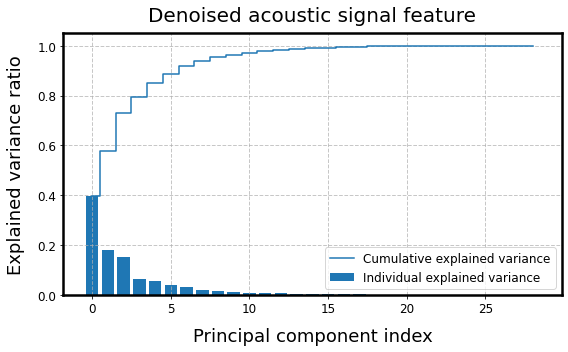

In [193]:
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot

plt.figure(figsize=(8, 5)) 
plt.grid(linestyle='--', linewidth=1, alpha=0.7)
plt.title("Denoised acoustic signal feature", fontsize = 20, pad = 12)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=1.0, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio', fontsize = 18, labelpad=12)
plt.xlabel('Principal component index', fontsize = 18, labelpad=12)
plt.legend(loc='best', fontsize="large")
plt.tight_layout()
# plt.show()
save_fig('PCA_all.png')

In [191]:
def plot_pca_explained_variance_ratio (df_signal_feature, name):
    pca= PCA()
    pca.fit(df_signal_feature)
    # print(pca.explained_variance_ratio_)
    exp_var_pca = pca.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    
    plt.figure(figsize=(8, 5)) 
    plt.grid(linestyle='--', linewidth=1, alpha=0.7)
    plt.title(name + " acoustic signal feature", fontsize = 20, pad = 12)
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=1.0, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio', fontsize = 18, labelpad=12)
    plt.xlabel('Principal component index', fontsize = 18, labelpad=12)
    plt.legend(loc='best', fontsize="large")
    plt.tight_layout()
    # plt.show()
    save_fig("PCA_" + name + ".png")

Saving figure PCA_Raw.png
Saving figure PCA_Equalized.png
Saving figure PCA_Bandpassed.png
Saving figure PCA_Denoised.png


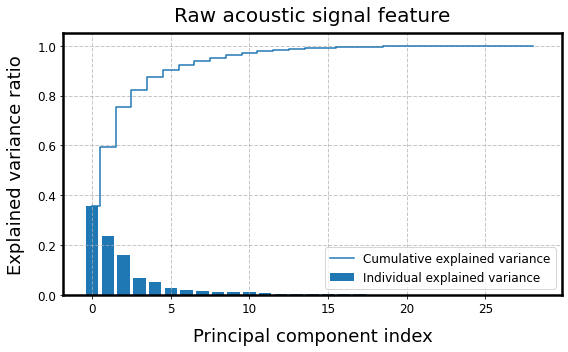

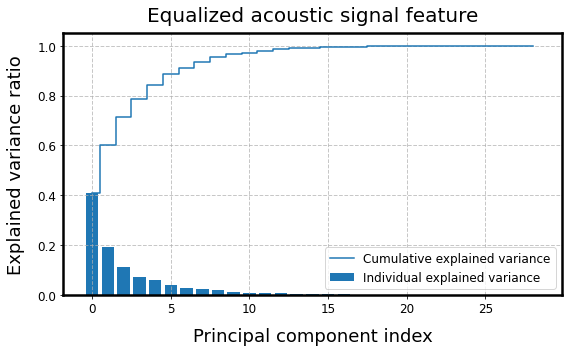

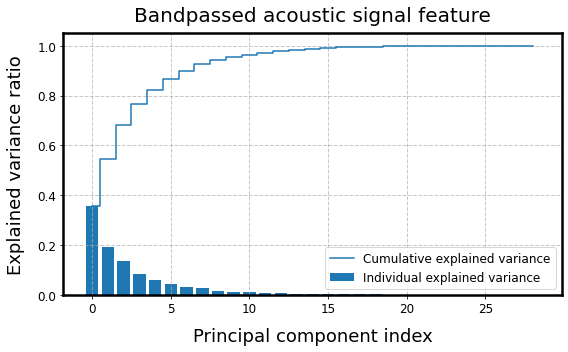

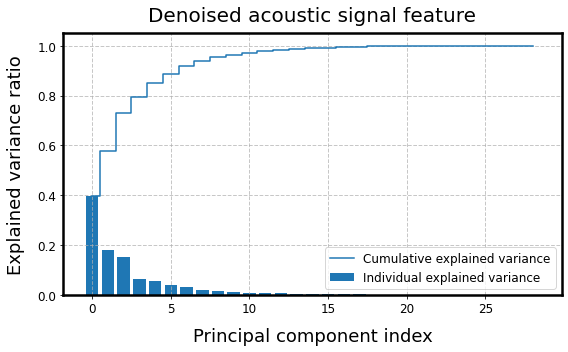

In [192]:
plot_pca_explained_variance_ratio(df_original_normalized, "Raw")
plot_pca_explained_variance_ratio(df_equalized_normalized, "Equalized")
plot_pca_explained_variance_ratio(df_bandpassed_normalized, "Bandpassed")
plot_pca_explained_variance_ratio(df_denoised_normalized, "Denoised")

### Only top 10 principle component are needed

In [194]:
import matplotlib.patches
    
def two_d_pca_projection (df_normalized, name):
    pca_2 = PCA(n_components=2)
    pca_2.fit(df_normalized)
    # dimensionality reduction -> output is reduced feature space
    data_pca_2 = pca_2.transform(df_normalized)

    plt.figure(figsize=(8, 6))
    levels, categories = pd.factorize(df_dataset_original_selected['Label'])
    colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
    handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

    xdata = data_pca_2[:, 0]
    ydata = data_pca_2[:, 1]

    plt.scatter(xdata, ydata, c=colors)
    plt.xlabel('Principal component 1',fontsize=20, labelpad=13)
    plt.ylabel('Principal component 2',fontsize=20, labelpad=13)
    plt.title('PCA Projection ' + name,fontsize=20, pad=12)
    # plt.gca().set(xlabel='Principle component 1', ylabel='Principle component 2', title='PCA dimensionality reduction', set_fontsize=12)
    plt.legend(handles=handles, loc='upper left', fontsize='large') # title='Color'
    save_fig("PCA_2D_" + name)

Saving figure PCA_2D_bandpassed


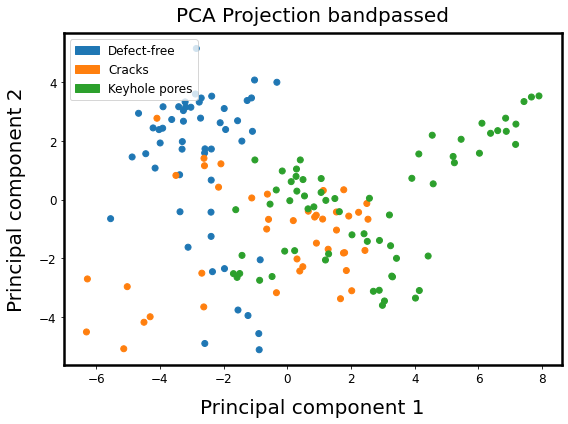

In [198]:
two_d_pca_projection(df_bandpassed_normalized, "bandpassed")

In [203]:
def three_d_pca_projection (df_normalized, name):
    pca_3 = PCA(n_components=3)
    pca_3.fit(df_normalized)
    # dimensionality reduction -> output is reduced feature space
    data_pca_3 = pca_3.transform(df_normalized)

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection='3d')

    levels, categories = pd.factorize(df_dataset_original_selected['Label'])
    colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
    handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]


    # Data for three-dimensional scattered points
    xdata = data_pca_3[:, 1]
    ydata = data_pca_3[:, 2]
    zdata = data_pca_3[:, 0]
    # ax.scatter3D(xdata, ydata, zdata,
    #              c=df_denoised_normalized["laser power"], edgecolor='none', alpha=0.9, s=40,
    #              cmap=plt.cm.get_cmap('Set1', 4)); # cmap='Greens'

    ax.scatter3D(xdata, ydata, zdata,edgecolor='none', alpha=1, s=90,
                 c=colors); # cmap='Greens'

    ax.set_xlabel('Principal component 1',fontsize=16, labelpad=13)
    ax.set_ylabel('Principal component 2',fontsize=16, labelpad=13)
    ax.set_zlabel('Principal component 3',fontsize=16, labelpad=13)
    ax.set_title("PCA 3D projection " + name, fontsize = 20, pad = 5)
    # plt.colorbar();
    plt.legend(handles=handles, loc='best', fontsize='large') #; upper left # title='Color'
    save_fig("PCA_3D_" + name)

Saving figure PCA_3D_(equalized)


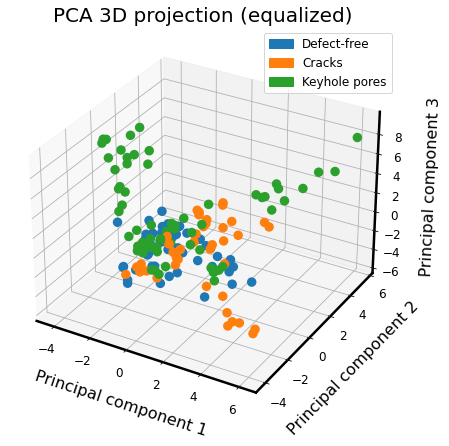

In [208]:
three_d_pca_projection(df_equalized_normalized, "(equalized)")

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston

# boston = load_boston()
# df = pd.DataFrame(boston.data, columns=boston.feature_names)
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(df_denoised_normalized)
# dimensionality reduction -> output is reduced feature space
data_pca = pca.transform(df_denoised_normalized)

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Experiment number' ## will be modified 

fig = px.scatter_matrix(
    data_pca, # components
    # color=boston.target,
    color = df_dataset_original_selected["Label"],
    symbol = df_dataset_original_selected["Label"],
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)


fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    font=dict(
        family="Arial", #"Courier New, monospace"
        size=16,
        color="black"
    ),

)

fig.update_traces(diagonal_visible=True)
# fig.show()
# fig.write_image("images/scatterogram_PCA10.svg")